In [63]:
# Pre Req Imports
import pandas as pd
import io
import os
import csv
import numpy as np
import requests
import json
import matplotlib.pyplot as plt # for plotting graphs

# Import API key
from config import api_key

# Define Excel Sheets

In [2]:
# Crime
# Table 3 is the largest and has the most useful data, crimes by type per suburb/town/postcode for each year from 2013 to 2022
xlsx = pd.ExcelFile("Data_Tables_LGA_Recorded_Offences_Year_Ending_December_2022.xlsx")
# Crime_By_Police_Region_Pop = pd.read_excel(xlsx, "Table 01") # Offences recorded and rate per 100,000 population by police region and local government area - January 2013 to December 2022
# Crime_By_Offence_Type_Pop = pd.read_excel(xlsx, "Table 02") # Offences recorded and rate per 100,000 population by offence type, local government area and police service area - January 2013 to December 2022
Crime_By_Offence_Type = pd.read_excel(xlsx, "Table 03") # Offences recorded by offence type, local government area and postcode or suburb/town - January 2013 to December 2022
# Crime_By_Location_Area = pd.read_excel(xlsx, "Table 04") # Offences recorded by location type and local government area - January 2013 to December 2022
# Crime_By_Investigation_Status = pd.read_excel(xlsx, "Table 05") # Offences recorded by investigation status and local government area - January 2013 to December 2022
# Crime_By_Drugs = pd.read_excel(xlsx, "Table 06") # Select drug offences by drug type and local government area - January 2013 to December 2022

In [3]:
# View the crimes dataframe 
Crime_By_Offence_Type.head()

,Year,Year ending,Local Government Area,Postcode,Suburb/Town Name,Offence Division,Offence Subdivision,Offence Subgroup,Offence Count
0,2022,December,Alpine,3691,Dederang,A Crimes against the person,Other crimes against the person,Other crimes against the person,2
1,2022,December,Alpine,3691,Dederang,B Property and deception offences,B40 Theft,B42 Steal from a motor vehicle,1
2,2022,December,Alpine,3691,Dederang,B Property and deception offences,B40 Theft,B49 Other theft,1
3,2022,December,Alpine,3691,Dederang,D Public order and security offences,D10 Weapons and explosives offences,D11 Firearms offences,1
4,2022,December,Alpine,3691,Dederang,D Public order and security offences,D20 Disorderly and offensive conduct,D22 Drunk and disorderly in public,1


In [4]:
# Obtain count of unique values in each column of crime table
for col in Crime_By_Offence_Type.columns:
    crime_unique_values = Crime_By_Offence_Type[col].nunique()
    print(col, crime_unique_values)

Year 10
Year ending 1
Local Government Area 79
Postcode 693
Suburb/Town Name 2851
Offence Division 6
Offence Subdivision 25
Offence Subgroup 106
Offence Count 739


In [5]:
# Groupby 'Year', 'suburb', 'division' and 'subdivision', summing 'offence count', dropping 'Year end' and 'offence subgroup'
crime_year_burb_div_sdiv = Crime_By_Offence_Type.groupby(["Year","Local Government Area", "Postcode", "Suburb/Town Name","Offence Division", "Offence Subdivision"])["Offence Count"].sum().reset_index().sort_values(by=["Year", "Suburb/Town Name", "Offence Subdivision"])
crime_year_burb_div_sdiv.to_csv("Resources/crime_year_burb_div_sdiv.csv", index=False)
crime_year_burb_div_sdiv.head()

,Year,Local Government Area,Postcode,Suburb/Town Name,Offence Division,Offence Subdivision,Offence Count
16123,2013,Yarra,3067,Abbotsford,A Crimes against the person,A20 Assault and related offences,40
16124,2013,Yarra,3067,Abbotsford,A Crimes against the person,A50 Robbery,4
16125,2013,Yarra,3067,Abbotsford,A Crimes against the person,"A70 Stalking, harassment and threatening behav...",6
16126,2013,Yarra,3067,Abbotsford,A Crimes against the person,A80 Dangerous and negligent acts endangering p...,7
16128,2013,Yarra,3067,Abbotsford,B Property and deception offences,B10 Arson,3


In [6]:
# Obtain count of unique values in each column of cleaned crime table
for col in crime_year_burb_div_sdiv.columns:
    crime_unique_values = crime_year_burb_div_sdiv[col].nunique()
    print(col, crime_unique_values)

Year 10
Local Government Area 79
Postcode 693
Suburb/Town Name 2851
Offence Division 6
Offence Subdivision 25
Offence Count 1151


In [7]:
# Property
xls = pd.ExcelFile("CleanSuburb_HouseV2021A.xls")
Property_Data = pd.read_excel(xls)

In [8]:
#View the property dataframe. Can drop 'Median 2011' and 'Median 2012' as no crime data for these years. 'Change' and 'Growth' columns can be dropped as not relevant to study questions.
Property_Data.head()

,locality,Median 2011,Median 2012,Median 2013,Median 2014,Median 2015,Median 2016,Median 2017,Median 2018,Median 2019,Median 2020,Median 2021,Median 2022,Change 2020-2021,Change 2011-2021,Growth PA
0,ABBOTSFORD,730000,714000,792500,862500,925000,1187500,1280000,1192500,1050000,1200000,1375000,1517500.0,15.0,88.0,6.5
1,ABERFELDIE,994000,852500,947500,1045000,1207500,1300000,1471000,1498500,1390000,1520000,1880500,1575000.0,24.0,89.0,6.6
2,AINTREE,-,-,-,-,600000,600000,571000,557500,575000,640000,719000,760000.0,12.0,NaN,NaN
3,AIREYS INLET,680000,634000,664000,625500,680000,715000,737500,869000,985000,1132500,1775000,1750000.0,57.0,161.0,10.1
4,AIRPORT WEST,557500,495000,532000,575000,635000,742000,845000,845000,795000,812500,960000,919500.0,18.0,72.0,5.6


In [9]:
# Convert 'locality' to title case in order to merge with 'Suberb/Town Name'
Property_Data['locality'] = Property_Data['locality'].astype(str).str.title()
Property_Data.head()

,locality,Median 2011,Median 2012,Median 2013,Median 2014,Median 2015,Median 2016,Median 2017,Median 2018,Median 2019,Median 2020,Median 2021,Median 2022,Change 2020-2021,Change 2011-2021,Growth PA
0,Abbotsford,730000,714000,792500,862500,925000,1187500,1280000,1192500,1050000,1200000,1375000,1517500.0,15.0,88.0,6.5
1,Aberfeldie,994000,852500,947500,1045000,1207500,1300000,1471000,1498500,1390000,1520000,1880500,1575000.0,24.0,89.0,6.6
2,Aintree,-,-,-,-,600000,600000,571000,557500,575000,640000,719000,760000.0,12.0,NaN,NaN
3,Aireys Inlet,680000,634000,664000,625500,680000,715000,737500,869000,985000,1132500,1775000,1750000.0,57.0,161.0,10.1
4,Airport West,557500,495000,532000,575000,635000,742000,845000,845000,795000,812500,960000,919500.0,18.0,72.0,5.6


In [10]:
# Delete columns for 2011 and 2012 plus the Change and Growth columns
Property_Data.drop(['Median 2011', 'Median 2012', 'Change 2020-2021', 'Change 2011-2021', 'Growth PA'], axis = 1, inplace=True)
Property_Data.head()

,locality,Median 2013,Median 2014,Median 2015,Median 2016,Median 2017,Median 2018,Median 2019,Median 2020,Median 2021,Median 2022
0,Abbotsford,792500,862500,925000,1187500,1280000,1192500,1050000,1200000,1375000,1517500.0
1,Aberfeldie,947500,1045000,1207500,1300000,1471000,1498500,1390000,1520000,1880500,1575000.0
2,Aintree,-,-,600000,600000,571000,557500,575000,640000,719000,760000.0
3,Aireys Inlet,664000,625500,680000,715000,737500,869000,985000,1132500,1775000,1750000.0
4,Airport West,532000,575000,635000,742000,845000,845000,795000,812500,960000,919500.0


In [11]:
# Convert all the Median house price columns to float datatype, or NaN if the value is a string
Property_Data[['Median 2013', 'Median 2014', 'Median 2015', 'Median 2016', 'Median 2017', 'Median 2018', 'Median 2019', 'Median 2020', 'Median 2021', 'Median 2022']] \
    = Property_Data[['Median 2013', 'Median 2014', 'Median 2015', 'Median 2016', 'Median 2017', 'Median 2018', 'Median 2019', 'Median 2020', 'Median 2021', 'Median 2022']] \
    .apply(pd.to_numeric, errors='coerce', downcast='float')
Property_Data.dtypes

locality        object
Median 2013    float32
Median 2014    float32
Median 2015    float32
Median 2016    float32
Median 2017    float32
Median 2018    float32
Median 2019    float32
Median 2020    float32
Median 2021    float32
Median 2022    float32
dtype: object

In [12]:
# Use AusPost postcode search to add Postcode to Property_Data
base_url = "https://digitalapi.auspost.com.au/postcode/search.json"
headers = {"auth-key": api_key}

# Make a copy of Property_Data
Property_Data_Postcodes = Property_Data.copy()
# Empty list to hold postcodes
postcodes = []

# Loop through Property_Data
for index, row in Property_Data_Postcodes.iterrows():
    locality = Property_Data_Postcodes.loc[index, 'locality']

    # Define parameters with 'locality', VIC, no postboxes
    params = {"q": locality, "state": "VIC", "excludePostBoxFlag": "true"}

    # Show search going on
    print(f"Looking up {locality}...")
    try:
        # Make the API request
        response = requests.get(base_url, headers=headers, params=params).json()
        
        # Result can be a list of dictionaries or just a single dictionary, depending on whether 'locality' is unique
        result = response["localities"]["locality"]
        
        if isinstance(result, list):
            # If result is a list, extract postcode from first dictionary
            postcode = result[0]["postcode"]
        else:
            # Otherwise extract postcode from unique dictionary
            postcode = result["postcode"]
    except:
        #If locality not found return 'Unknown'
        postcode = "Unknown"
    # Store returned postcodes in list
    postcodes.append(postcode)
    # Show result of search
    print(f"...found postcode {postcode}")

# Add finished postcode list to Properta_Data after locality column   
Property_Data_Postcodes.insert(1, "Postcode", postcodes)
# Write to csv
Property_Data_Postcodes.to_csv('Resources/Property_Data_Postcodes.csv')
Property_Data_Postcodes.head()

Looking up Abbotsford...
...found postcode 3067
Looking up Aberfeldie...
...found postcode 3040
Looking up Aintree...
...found postcode 3336
Looking up Aireys Inlet...
...found postcode 3231
Looking up Airport West...
...found postcode 3042
Looking up Albanvale...
...found postcode 3021
Looking up Albert Park...
...found postcode 3206
Looking up Albion...
...found postcode 3020
Looking up Alexandra...
...found postcode 3714
Looking up Alfredton...
...found postcode 3350
Looking up Allansford...
...found postcode 3277
Looking up Alphington...
...found postcode 3078
Looking up Altona...
...found postcode 3018
Looking up Altona East...
...found postcode 3025
Looking up Altona Meadows...
...found postcode 3028
Looking up Altona North...
...found postcode 3025
Looking up Anglesea...
...found postcode 3230
Looking up Apollo Bay...
...found postcode 3233
Looking up Ararat...
...found postcode 3377
Looking up Ardeer...
...found postcode 3022
Looking up Armadale...
...found postcode 3143
Lookin

,locality,Postcode,Median 2013,Median 2014,Median 2015,Median 2016,Median 2017,Median 2018,Median 2019,Median 2020,Median 2021,Median 2022
0,Abbotsford,3067,792500.0,862500.0,925000.0,1187500.0,1280000.0,1192500.0,1050000.0,1200000.0,1375000.0,1517500.0
1,Aberfeldie,3040,947500.0,1045000.0,1207500.0,1300000.0,1471000.0,1498500.0,1390000.0,1520000.0,1880500.0,1575000.0
2,Aintree,3336,NaN,NaN,600000.0,600000.0,571000.0,557500.0,575000.0,640000.0,719000.0,760000.0
3,Aireys Inlet,3231,664000.0,625500.0,680000.0,715000.0,737500.0,869000.0,985000.0,1132500.0,1775000.0,1750000.0
4,Airport West,3042,532000.0,575000.0,635000.0,742000.0,845000.0,845000.0,795000.0,812500.0,960000.0,919500.0


In [13]:
# Melt the property table to match crime table format
melted_property_data_postcode = Property_Data_Postcodes.melt(id_vars=['locality', 'Postcode'], var_name='year', value_name='Median')

# Extract year from column name and convert to integer
melted_property_data_postcode['year'] = melted_property_data_postcode['year'].str.extract('(\d+)').astype(int)

# Sort the dataframe by locality and year
melted_property_data_postcode = melted_property_data_postcode.sort_values(['locality', 'year'])

# Reset index
melted_property_data_postcode = melted_property_data_postcode.reset_index(drop=True)

print(melted_property_data_postcode.head())

     locality Postcode  year     Median
0  Abbotsford     3067  2013   792500.0
1  Abbotsford     3067  2014   862500.0
2  Abbotsford     3067  2015   925000.0
3  Abbotsford     3067  2016  1187500.0
4  Abbotsford     3067  2017  1280000.0


In [14]:
# Use 'Suburb/Town Name' and 'localities' to merge cleaned Crime and Property dataframes using an inner join.
crime_property_merged = pd.merge(crime_year_burb_div_sdiv, melted_property_data_postcode, left_on=["Year", "Suburb/Town Name"], right_on = ["year", "locality"], how = 'inner')
crime_property_merged.head()


,Year,Local Government Area,Postcode_x,Suburb/Town Name,Offence Division,Offence Subdivision,Offence Count,locality,Postcode_y,year,Median
0,2013,Yarra,3067,Abbotsford,A Crimes against the person,A20 Assault and related offences,40,Abbotsford,3067,2013,792500.0
1,2013,Yarra,3067,Abbotsford,A Crimes against the person,A50 Robbery,4,Abbotsford,3067,2013,792500.0
2,2013,Yarra,3067,Abbotsford,A Crimes against the person,"A70 Stalking, harassment and threatening behav...",6,Abbotsford,3067,2013,792500.0
3,2013,Yarra,3067,Abbotsford,A Crimes against the person,A80 Dangerous and negligent acts endangering p...,7,Abbotsford,3067,2013,792500.0
4,2013,Yarra,3067,Abbotsford,B Property and deception offences,B10 Arson,3,Abbotsford,3067,2013,792500.0


In [15]:
# Create six different crime_property_merge csv files from the main merge file above, each one named for, and only containing rows corresponding to one of the six 'Offence Division's
offence_div = crime_property_merged['Offence Division'].unique()
for div in offence_div:
    crime_div_property_merged = crime_property_merged[crime_property_merged['Offence Division'] == div]
    crime_div_property_merged.to_csv(f'Resources/{div}.csv', index=False)

# Merged Data
The `Resources` folder contains the following working csv files:
- `A Crimes against the person.csv`
- `B Property and deception offences.csv`
- `C Drug offences.csv`
- `D Public order and security offences.csv`
- `E Justice procedures offences.csv`
- `F Other offences.csv`

Each is a merge of cleaned crimes inner joined to cleaned property by matching suburb name.

In [24]:
assault_data = crime_property_merged[crime_property_merged["Offence Subdivision"] == "A20 Assault and related offences"]
grouped_data = assault_data.groupby("Offence Count").count()
assault_data.head()

,Year,Local Government Area,Postcode_x,Suburb/Town Name,Offence Division,Offence Subdivision,Offence Count,locality,Postcode_y,year,Median
0,2013,Yarra,3067,Abbotsford,A Crimes against the person,A20 Assault and related offences,40,Abbotsford,3067,2013,792500.0
18,2013,Moonee Valley,3040,Aberfeldie,A Crimes against the person,A20 Assault and related offences,11,Aberfeldie,3040,2013,947500.0
43,2013,Moonee Valley,3042,Airport West,A Crimes against the person,A20 Assault and related offences,41,Airport West,3042,2013,532000.0
61,2013,Brimbank,3021,Albanvale,A Crimes against the person,A20 Assault and related offences,42,Albanvale,3021,2013,313000.0
80,2013,Port Phillip,3206,Albert Park,A Crimes against the person,A20 Assault and related offences,26,Albert Park,3206,2013,1360000.0


In [40]:
summed_data = assault_data.groupby(["locality", "Year"])["Offence Count", "Median"].sum().reset_index()
summed_data = summed_data.rename(columns={"Offence Count": "Total Assault Offences", "locality": "Suburb"})
summed_data.head(20)

C:\Users\Roberto\AppData\Local\Temp\ipykernel_15968\1272632060.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summed_data = assault_data.groupby(["locality", "Year"])["Offence Count", "Median"].sum().reset_index()


,Suburb,Year,Total Assault Offences,Median
0,Abbotsford,2013,40,792500.0
1,Abbotsford,2014,49,862500.0
2,Abbotsford,2015,48,925000.0
3,Abbotsford,2016,72,1187500.0
4,Abbotsford,2017,79,1280000.0
5,Abbotsford,2018,61,1192500.0
6,Abbotsford,2019,98,1050000.0
7,Abbotsford,2020,82,1200000.0
8,Abbotsford,2021,90,1375000.0
9,Abbotsford,2022,100,1517500.0


In [77]:
# Data from the year 2013 only
summed_data_2013 = assault_data[assault_data["Year"] == 2013].groupby(["Year", "locality"])[["Offence Count", "Median"]].sum().reset_index()
summed_data_2013 = summed_data_2013.rename(columns={"Offence Count": "Total Assault Offences", "locality": "Suburb"})
# summed_data_2013.sort_values(by="Total Assault Offences" , ascending=False).tail(50)
summed_data_2013.head(50)

,Year,Suburb,Total Assault Offences,Median
0,2013,Abbotsford,40,792500.0
1,2013,Aberfeldie,11,947500.0
2,2013,Airport West,41,532000.0
3,2013,Albanvale,42,313000.0
4,2013,Albert Park,26,1360000.0
5,2013,Albion,32,379000.0
6,2013,Alexandra,13,261000.0
7,2013,Alfredton,23,361500.0
8,2013,Allansford,5,310000.0
9,2013,Alphington,7,2160000.0


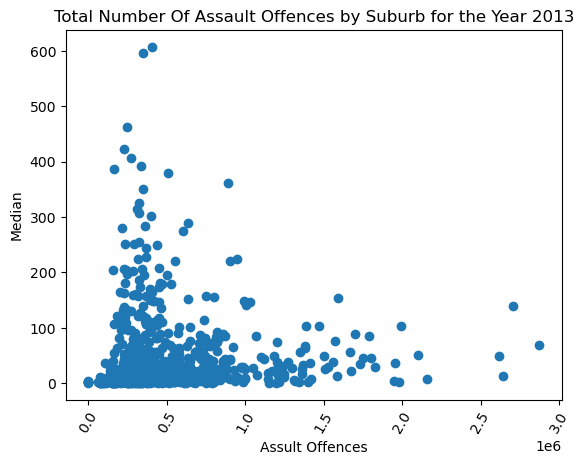

In [85]:
# Scatter Plot
plt.scatter(summed_data_2013["Median"], summed_data_2013["Total Assault Offences"])

plt.title("Total Number Of Assault Offences by Suburb for the Year 2013")
plt.ylabel("Median")
plt.xlabel("Assult Offences")

plt.xticks(rotation=60)
plt.show()

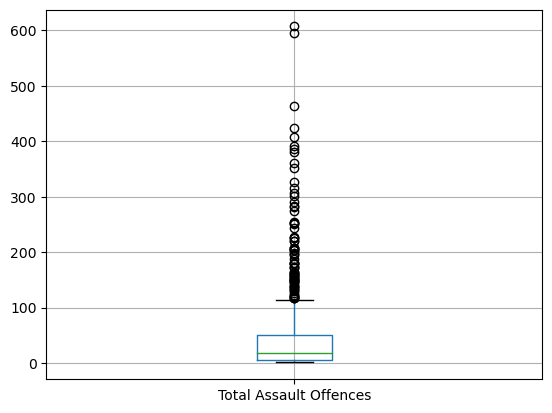

In [80]:
# Sample
boxplot = summed_data_2013.boxplot(column="Total Assault Offences")
plt.show()